<a href="https://drive.google.com/file/d/1-lmvLqHRoVztabnwQ8RbZuDhpsd1kmYY/view?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Research project** for the course of *Selected Topics in Music and Acoustic Engineering* :

***Music Instrument Classification***
---
Team:
* Andrea Crisafulli
* Marco Porcella
* Giacomo De Toni
* Gianluigi Vecchini

### *Import libraries*:

In [1]:
# === Core Python & Scientific Computing ===
import numpy as np                # Numerical computing
import pandas as pd              # Data handling and manipulation
import matplotlib.pyplot as plt  # Plotting
from pathlib import Path         # File path handling
import scipy.signal as signal    # Signal processing tools

# === Audio Processing ===
import librosa                   # Audio analysis
import librosa.display           # Visualization for librosa outputs
import IPython.display as ipd    # For audio playback in notebooks

# === Scikit-learn: ML & Preprocessing ===
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay  # Evaluation
from sklearn.decomposition import PCA         # Dimensionality reduction
from sklearn.preprocessing import scale, StandardScaler, MultiLabelBinarizer  # Data scaling & encoding
from sklearn.model_selection import train_test_split  # Dataset splitting
from sklearn.svm import SVC                    # Support Vector Classifier
from sklearn.neighbors import KNeighborsClassifier  # k-NN classifier
from sklearn.cluster import KMeans            # Clustering

# === Deep Learning: TensorFlow / Keras ===
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint  # Training utilities
from keras.optimizers import Adam            # Optimizer for model training
from keras import layers, models

# === Optional: PyTorch (if used) ===
#import torch
#import torch.nn as nn
#import torch.nn.functional as F              # Functional API for building models

# === Others ===
import yaml                                   # Parsing metadata in YAML format
from collections import Counter               # Frequency counting for label analysis
from tqdm import tqdm                         # Progress bar for loops

# === Plotting Style ===
plt.style.use("seaborn-v0_8")                 # Set default plotting style

2025-06-04 18:27:54.907322: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Import audio data.

In [41]:
#basePath = Path("E:/MedleyDB")                         # For windows
basePath = Path("/Volumes/Extreme SSD/MedleyDB")        # For mac
audioPath = basePath / "Audio"
data = []

# Iterates over directories in the melodyDB/Audio folder
for songDir in audioPath.iterdir():
    labelArray = []
    
    # Security check to skip not directory items
    if not songDir.is_dir():
        continue
    
    songName = songDir.name
    yamlFilePath = audioPath / songDir / f"{songName}_METADATA.yaml" # Path to YAML metadata file
    
    # Opens YAML metadata file in read mode
    with open(yamlFilePath, "r") as f:
        metadata = yaml.safe_load(f)
    
    # Recovers stems from metadata and stores in dictionary
    stemsData = metadata.get("stems", {})
    
    # Iterates over stems
    for stemId, stem in stemsData.items():
        instrumentData = [] # Empty data for raw paths
        
        rawData = stem.get("raw", {})
        
        # import Raw files 
        # Iterates over raw items to store the relative paths
        #for rawId, raw in rawData.items():
            #rawPath = songDir /  f"{songName}_RAW" / raw.get("filename")
            
            # Checks for valid files
            #if(not rawPath.name.startswith(".")):
            #    newData = {
            #        "song": songName,
            #        "songPath": audioPath / songDir,
            #        "label": stem.get("instrument"),
            #        "filePath": rawPath
            #    }
            #    
            #    data.append(newData)
        
        # Creates new data
        newData = {
            "song": songName,
            "songPath": songDir,
            "label": stem.get("instrument"),
            "filePath": songDir / f"{songName}_STEMS" / stem.get("filename")
        }
        
        # Appends to data 
        data.append(newData)
        
        labelArray.append(stem.get("instrument"))
    
    # Format    
    labelFormatted = "|".join(sorted(set(labelArray)))
    
    mixData = {
        "song": songName,
        "songPath": audioPath / songDir,
        "label": labelFormatted,
        "filePath": songDir / f"{songName}_MIX.wav"
    }
    
    data.append(mixData)
# Create DataFrame
df = pd.DataFrame(data)
print(f"Loaded {len(df)} audio files.")

# String convertion to list
df["labelList"] = df["label"].str.split("|")

mlb = MultiLabelBinarizer()
audioLabelsBinary = mlb.fit_transform(df["labelList"])
audioLabelsBinary = np.asarray(audioLabelsBinary)

Loaded 978 audio files.


In [24]:
df.head()

,song,songPath,label,filePath,labelList
0,AClassicEducation_NightOwl,/Volumes/Extreme SSD/MedleyDB/Audio/AClassicEd...,electric bass,/Volumes/Extreme SSD/MedleyDB/Audio/AClassicEd...,[electric bass]
1,AClassicEducation_NightOwl,/Volumes/Extreme SSD/MedleyDB/Audio/AClassicEd...,drum set,/Volumes/Extreme SSD/MedleyDB/Audio/AClassicEd...,[drum set]
2,AClassicEducation_NightOwl,/Volumes/Extreme SSD/MedleyDB/Audio/AClassicEd...,distorted electric guitar,/Volumes/Extreme SSD/MedleyDB/Audio/AClassicEd...,[distorted electric guitar]
3,AClassicEducation_NightOwl,/Volumes/Extreme SSD/MedleyDB/Audio/AClassicEd...,distorted electric guitar,/Volumes/Extreme SSD/MedleyDB/Audio/AClassicEd...,[distorted electric guitar]
4,AClassicEducation_NightOwl,/Volumes/Extreme SSD/MedleyDB/Audio/AClassicEd...,clean electric guitar,/Volumes/Extreme SSD/MedleyDB/Audio/AClassicEd...,[clean electric guitar]


In [25]:
df.tail()

,song,songPath,label,filePath,labelList
973,TheSoSoGlos_Emergency,/Volumes/Extreme SSD/MedleyDB/Audio/TheSoSoGlo...,vibraphone,/Volumes/Extreme SSD/MedleyDB/Audio/TheSoSoGlo...,[vibraphone]
974,TheSoSoGlos_Emergency,/Volumes/Extreme SSD/MedleyDB/Audio/TheSoSoGlo...,acoustic guitar|auxiliary percussion|distorted...,/Volumes/Extreme SSD/MedleyDB/Audio/TheSoSoGlo...,"[acoustic guitar, auxiliary percussion, distor..."
975,Wolf_DieBekherte,/Volumes/Extreme SSD/MedleyDB/Audio/Wolf_DieBe...,female singer,/Volumes/Extreme SSD/MedleyDB/Audio/Wolf_DieBe...,[female singer]
976,Wolf_DieBekherte,/Volumes/Extreme SSD/MedleyDB/Audio/Wolf_DieBe...,piano,/Volumes/Extreme SSD/MedleyDB/Audio/Wolf_DieBe...,[piano]
977,Wolf_DieBekherte,/Volumes/Extreme SSD/MedleyDB/Audio/Wolf_DieBe...,female singer|piano,/Volumes/Extreme SSD/MedleyDB/Audio/Wolf_DieBe...,"[female singer, piano]"


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 978 entries, 0 to 977
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   song       978 non-null    object
 1   songPath   978 non-null    object
 2   label      978 non-null    object
 3   filePath   978 non-null    object
 4   labelList  978 non-null    object
dtypes: object(5)
memory usage: 38.3+ KB


In [27]:
audioFiles = []
audioLabels = []

# Extract paths and labels
for _, row in df.iterrows():
    audioFiles.append(row["filePath"])
    audioLabels.append(row["labelList"])
    

# Security check
if(len(audioFiles) == len(audioLabels)):
    print(f"Extracted files and labels for a total lenght of {len(audioFiles)}")
else:
    print("Error in dataset")

Extracted files and labels for a total lenght of 978


In [7]:
########################################################
######## ONLY TO EXTRACT 3 MOST PRESENT LABELS #########
########################################################
n_classes_test = 3

# Flatten all labels e conta frequenze
all_labels = sum(df["labelList"], [])
label_counts = Counter(all_labels)

# Prendi le 10 classi più frequenti
top_labels = [label for label, _ in label_counts.most_common(n_classes_test)]
print("Top labels:", top_labels)

# Filtra righe dove almeno una label è in top_labels
df_subset = df[df["labelList"].apply(lambda labels: any(label in top_labels for label in labels))]

# Estrai audio e label
audioFilesSubset = df_subset["filePath"].tolist()
audioLabelsSubset = df_subset["labelList"].tolist()
audioLabelsSubsetBinary = audioLabelsBinary[df_subset.index]
audioLabelsSubsetBinary = np.asarray(audioLabelsSubsetBinary)

if len(audioFilesSubset) == len(audioLabelsSubset):
    print(f"Extracted {len(audioFilesSubset)} samples from top {n_classes_test} labels")
else:
    print("Mismatch in extracted data")

print(f"Subset binary label matrix shape: {audioLabelsSubsetBinary.shape}")

Top labels: ['drum set', 'vocalists', 'electric bass']
Extracted 876 samples from top 3 labels
Subset binary label matrix shape: (876, 82)


In [66]:
# Load data

# For now we are extracting only 10 signals
audioFilesToExtract = audioFiles[0:10]
labelsToLoad = audioLabelsBinary[0:10]

signals = []

timeExtraction = 3
samplingRate = 22050
minAmplitude = 0.5

#for file in tqdm(audioFilesSubset, desc="Loading audio files..."):
#    y, _ = librosa.load(file, sr=22050)
#    signals.append(y)

# For now we are extracting only 10 signals
for x in tqdm(audioFilesToExtract[0:10], desc="Loading audio files..."):
    y, _ = librosa.load(x, sr=22050)
    
    # Normalization of signal n
    if np.max(np.abs(y)) > 0:
        y = y / np.max(np.abs(y))
        
        # Find the first non-zero sample
        start_index = np.argmax(y > minAmplitude)
        num_samples = int(samplingRate * timeExtraction)
        end_index = start_index + num_samples
        y = y[start_index:end_index]
    
    signals.append(y)

Loading audio files...: 100%|██████████| 10/10 [00:02<00:00,  4.65it/s]


In [67]:
melSpegrams = []

# Iterates over signals, normalizes them and computes mel spectrograms via librosa feature
for signal in tqdm(signals, desc="Processing audio signals..."):

    # Creation of mel spectrogram
    S = librosa.feature.melspectrogram(y=signal, sr=22050)
    S_dB = librosa.power_to_db(S, ref=np.max)
    melSpegrams.append(S_dB)

Processing audio signals...: 100%|██████████| 10/10 [00:00<00:00, 114.04it/s]




-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
Labels: ('electric bass',)


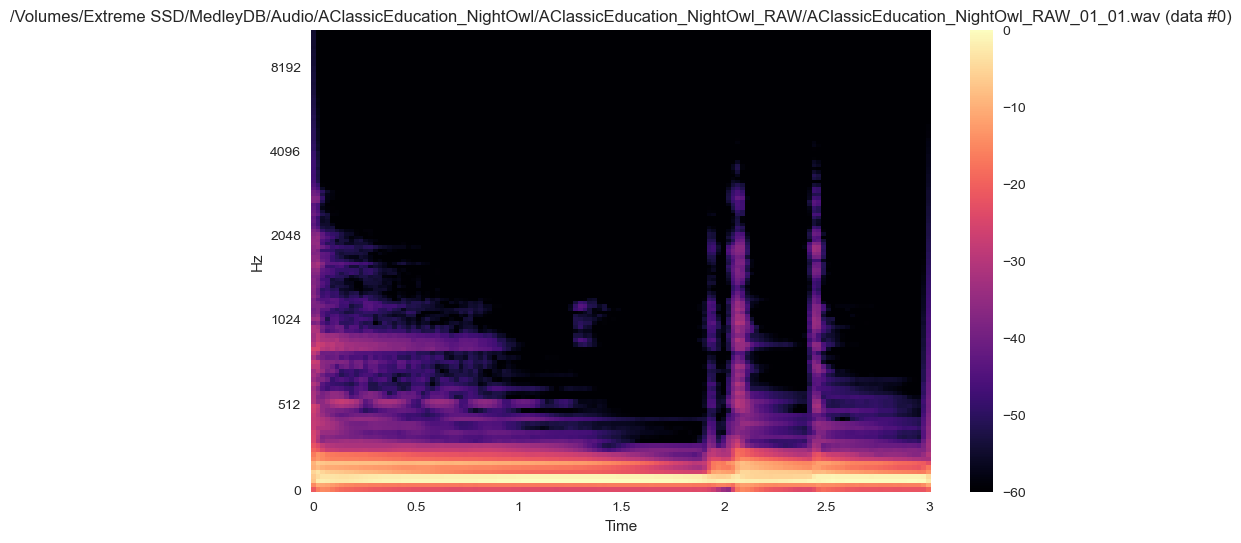



-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
Labels: ('drum set',)


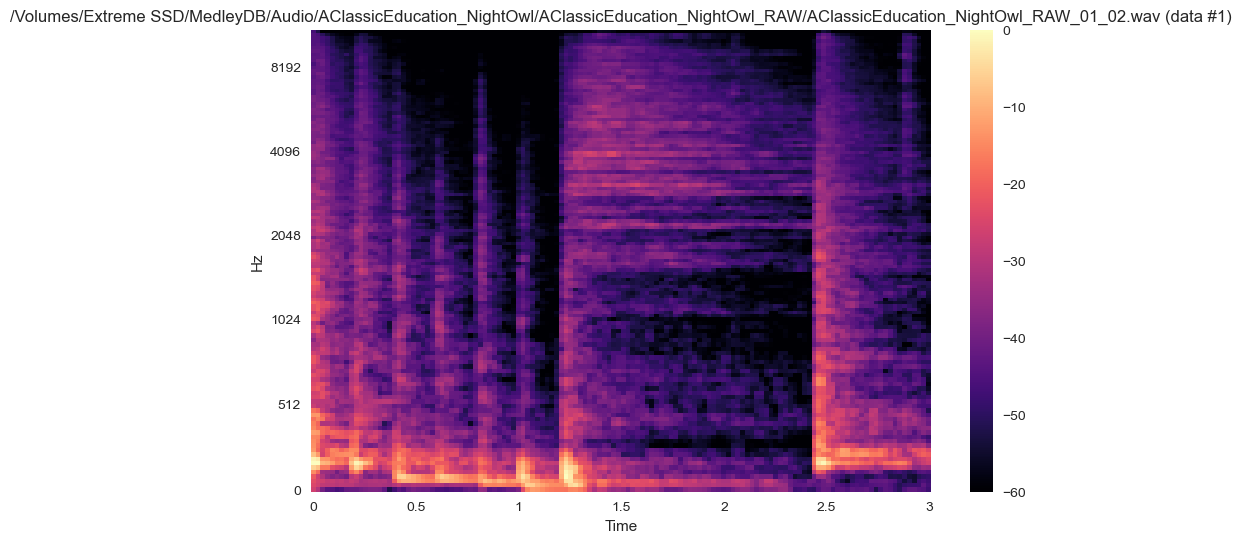



-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
Labels: ('distorted electric guitar',)


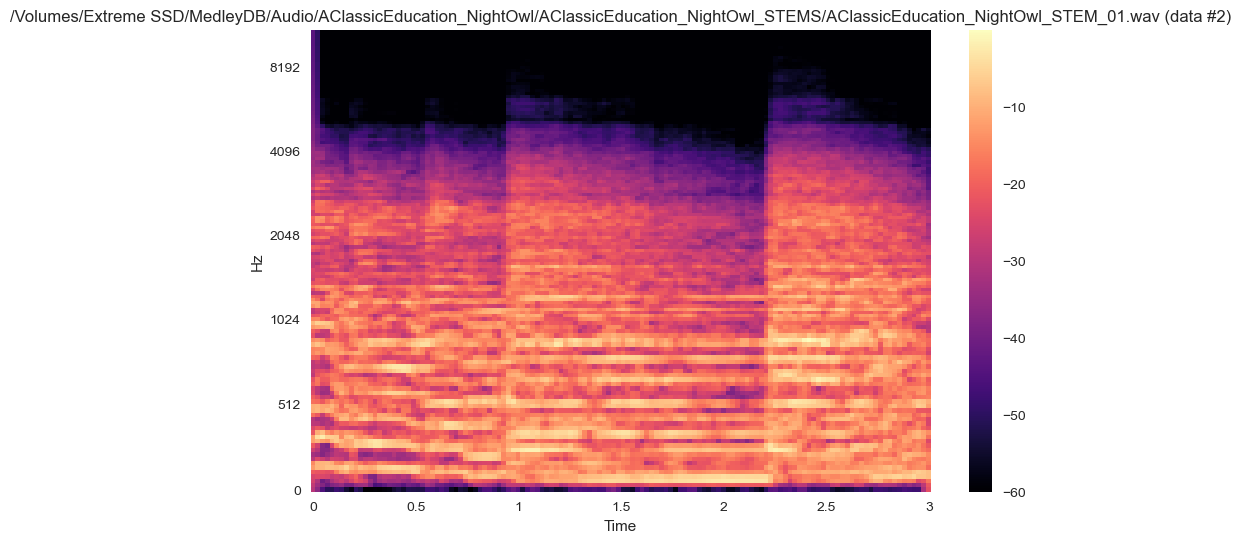



-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
Labels: ('distorted electric guitar',)


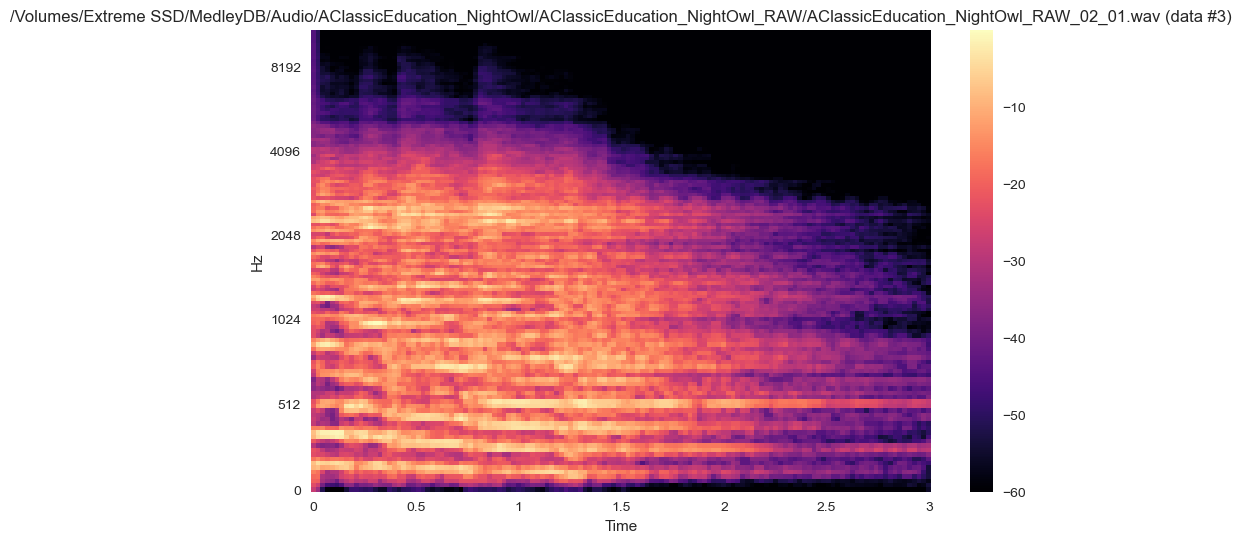



-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
Labels: ('clean electric guitar',)


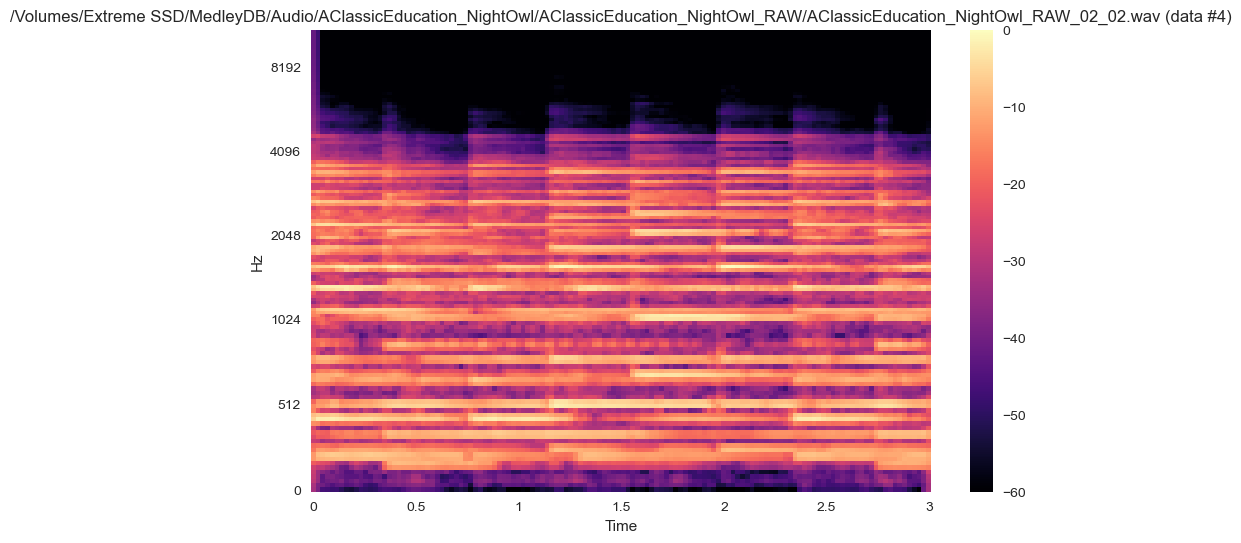



-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
Labels: ('distorted electric guitar',)


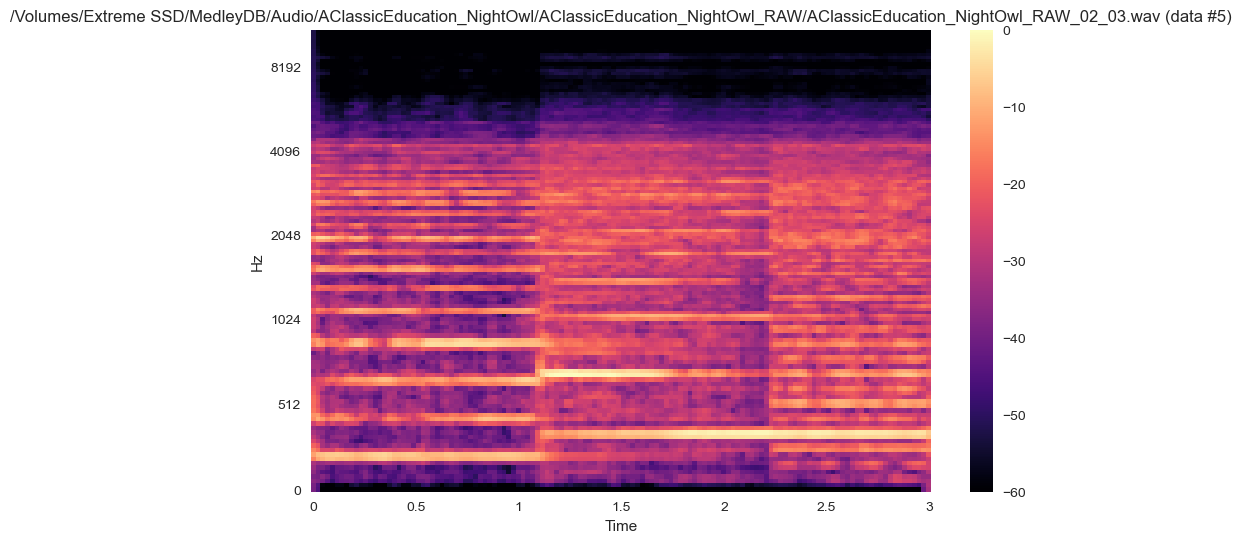



-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
Labels: ('distorted electric guitar',)


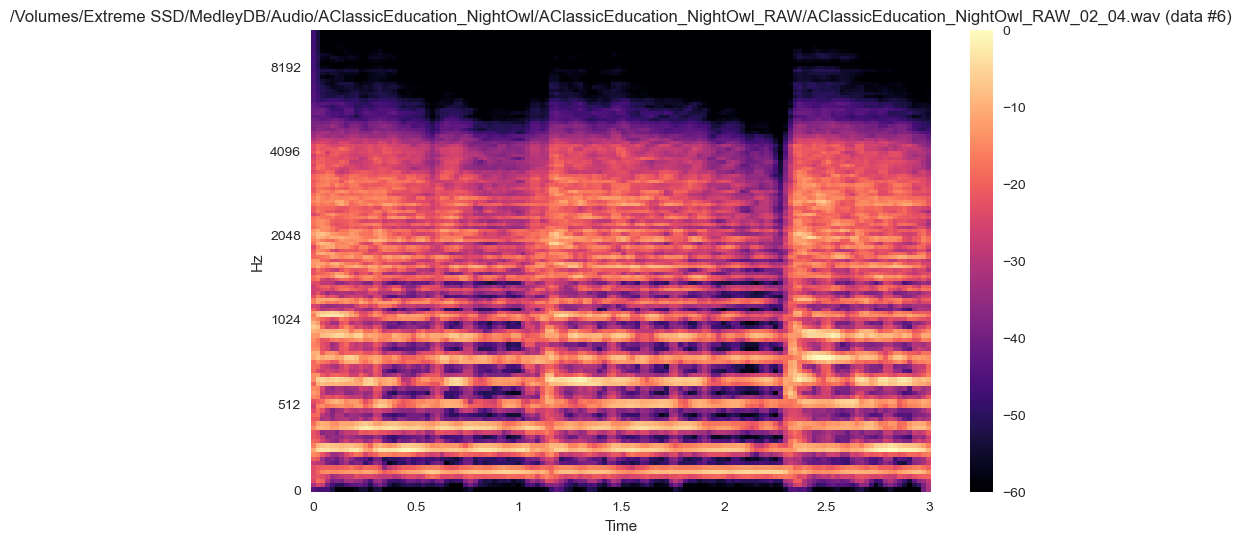



-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
Labels: ('male singer',)


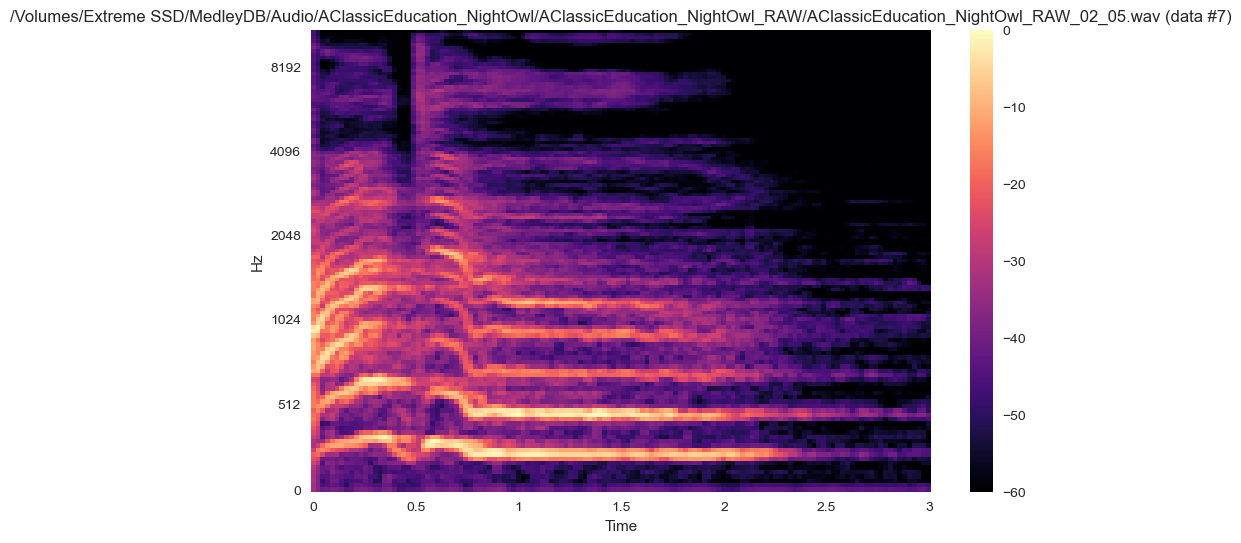



-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
Labels: ('synthesizer',)


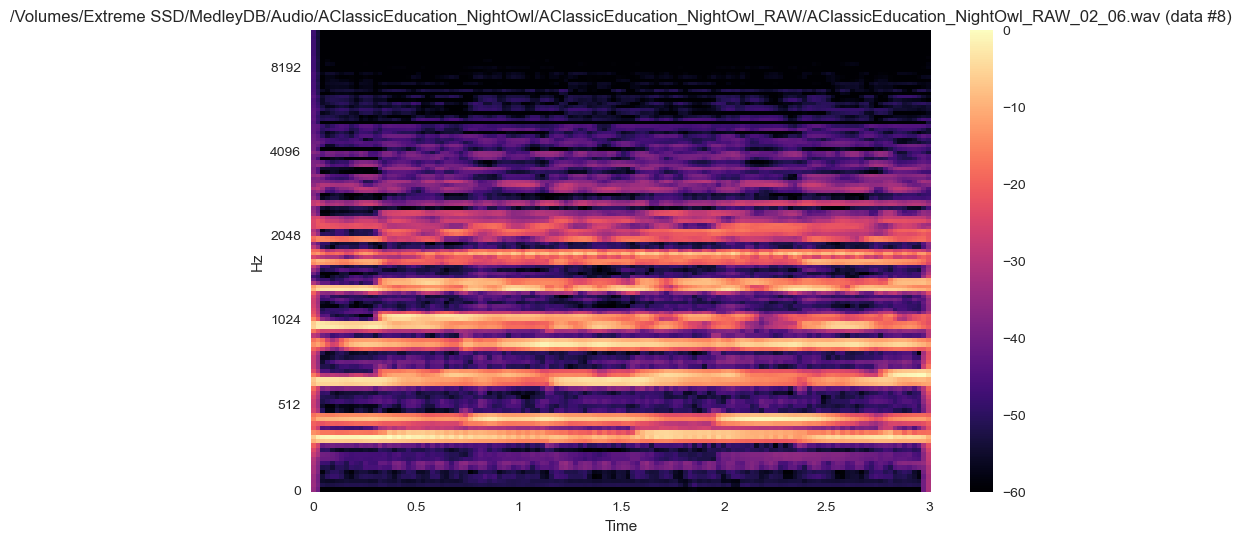



-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
Labels: ('vocalists',)


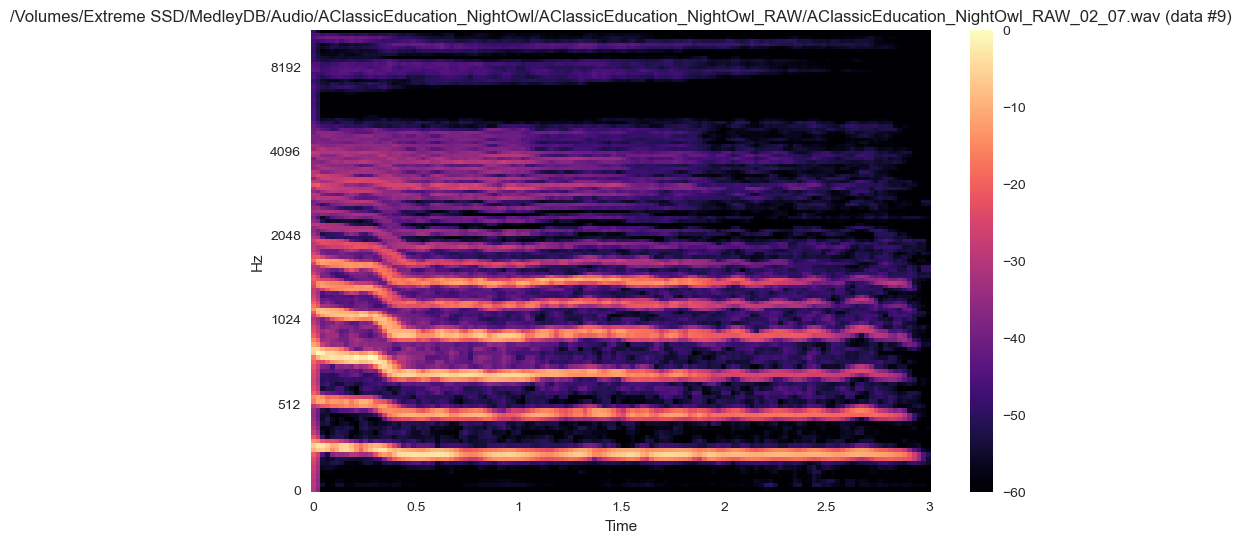

In [68]:
# Plot of spectrogram n=0
import IPython.display

for i in range(0, len(signals), int(len(signals)/10)):
    print("\n\n-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-")
    
    original_labels = mlb.inverse_transform(np.array([audioLabelsBinary[i]]))[0]
    print("Labels:", original_labels)

    IPython.display.display(IPython.display.Audio(signals[i], rate=22050))

    plt.figure(figsize=(10,6))
    librosa.display.specshow(melSpegrams[i], sr=22050, x_axis='time', y_axis='mel', fmax=22050/2)
    plt.clim(-60,None)
    plt.colorbar()

    filename = str(audioFilesSubset[i]).split("\\")[-1]
    
    plt.title(f'{filename} (data #{i})')
    plt.show()

The user now has to choose which data he wants to load

In [69]:
# Split into Train (70%) and Temp (30%)
# X = mel spectrograms
# y = label
X_train, X_temp, y_train, y_temp = train_test_split(
    melSpegrams, labelsToLoad, test_size=0.30, random_state=42
)

# Split Temp into Validation (15%) and Test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

# Summary
print(f"Train samples:      {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples:       {len(X_test)}")
print(f"Test lables:       {len(y_train)}")
print(f"Validation lables: {len(y_val)}")
print(f"Test lables:       {len(y_test)}")

Train samples:      7
Validation samples: 1
Test samples:       2
Test lables:       7
Validation lables: 1
Test lables:       2


In [73]:
# === Define input shape and number of output classes ===
inputShape = (128, melSpegrams[0].shape[1], 1)  # (n_mels, time_frames, channels)
numClasses = labelsToLoad.shape[1]  # number of multilabel classes

# === Build CNN model ===
modelCNN = models.Sequential([

    # Input
    layers.Input(shape=inputShape),

    # === Block 1 ===
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((3, 3), padding='same'),
    layers.Dropout(0.25),
    layers.BatchNormalization(),

    # === Block 2 ===
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((3, 3), padding='same'),
    layers.Dropout(0.25),
    layers.BatchNormalization(),

    # === Block 3 ===
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((3, 3), padding='same'),
    layers.Dropout(0.25),
    layers.BatchNormalization(),

    # === Block 4 ===
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.GlobalMaxPooling2D(),
    layers.Dropout(0.25),
    layers.BatchNormalization(),

    # === Fully Connected ===
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),

    # === Output Layer (sigmoid for multilabel) ===
    layers.Dense(numClasses, activation='sigmoid')
])

# === Compile the model ===
modelCNN.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# === Summary ===
modelCNN.summary()

# Optional: show classes
print(f"Number of classes: {numClasses}")
print(f"Class names: {mlb.classes_}")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 128, 130, 32)      320       
                                                                 
 conv2d_17 (Conv2D)          (None, 128, 130, 32)      9248      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 43, 44, 32)        0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 43, 44, 32)        0         
                                                                 
 batch_normalization_8 (Bat  (None, 43, 44, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_18 (Conv2D)          (None, 43, 44, 64)       

In [39]:
from keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint

# Path to save logs and models
csvLogPath = 'training_log.csv'
checkpointPath = 'best_model.h5'

# CSVLogger: logs every epoch to CSV
csvLogger = CSVLogger(csvLogPath, append=True)

# EarlyStopping: stop if val_loss doesn't improve after 100 epochs
earlyStop = EarlyStopping(
    monitor='val_accuracy',
    patience=100,
    restore_best_weights=True,
    verbose=1
)

# ModelCheckpoint: save best model based on val_accuracy
checkpoint = ModelCheckpoint(
    filepath=checkpointPath,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Bundle them
callbacks = [csvLogger, earlyStop, checkpoint]

In [40]:
from keras.optimizers import Adam

# Compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
modelCNN.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

batchSize=32
epochs=300

history = modelCNN.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=batchSize, epochs=epochs, verbose=0, callbacks = callbacks)

ValueError: Data cardinality is ambiguous:
  x sizes: 128, 128, 128, 128, 128, 128, 128
  y sizes: 7
Make sure all arrays contain the same number of samples.

Best validation accuracy:  0.0


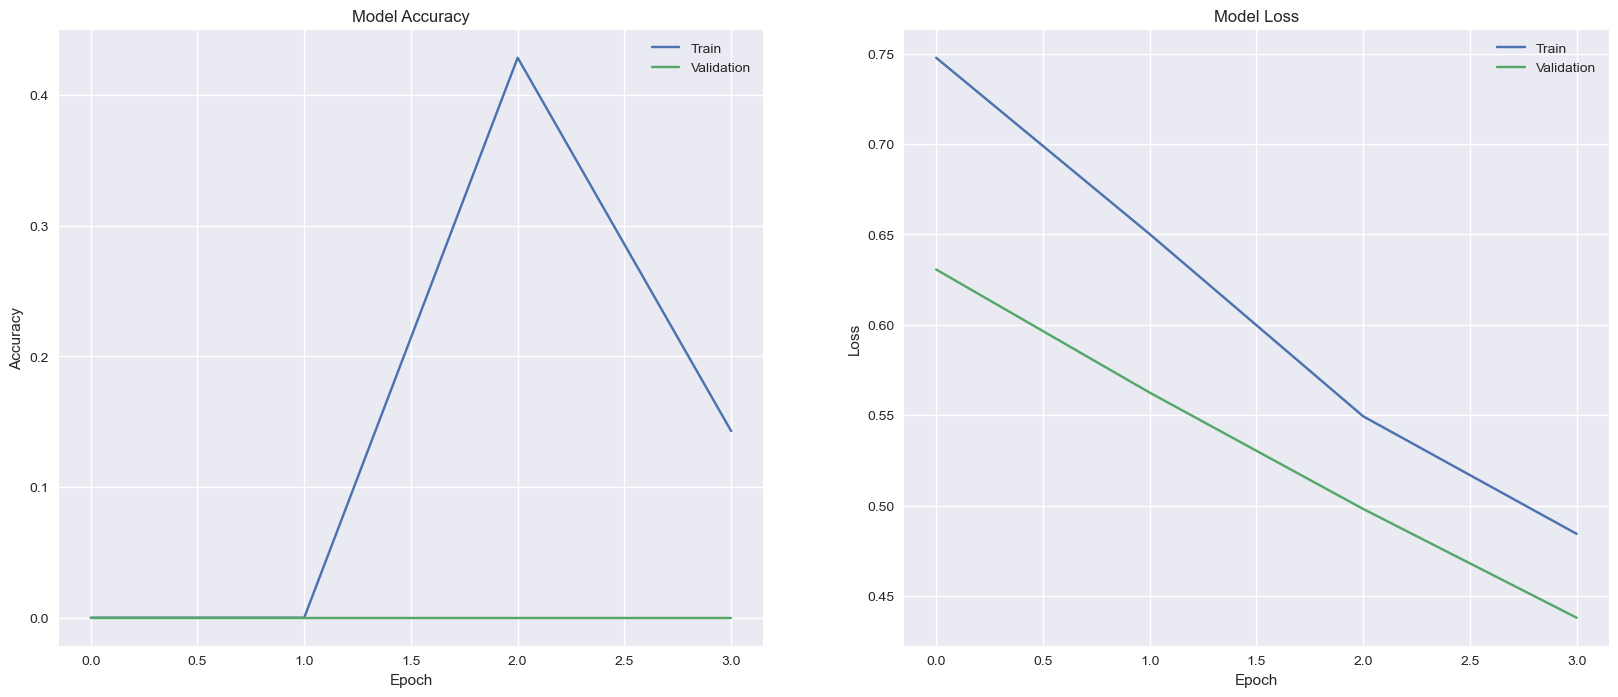

In [18]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy']) 
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
#plt.ylim(0, 1)


plt.subplot(1,2,2)
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
#plt.ylim(0, 2);

#best validation accuracy
bestValAccuracy = np.max(history.history['val_accuracy'])
print('Best validation accuracy: ', bestValAccuracy)

In [19]:
testLoss, testAccuracy = modelCNN.evaluate(X_test, y_test, verbose=0)

print(f"Test Accuracy: {testAccuracy:.4f}")

Test Accuracy: 0.0000


In [22]:
modelCNN.load_weights(str('best_model.hdf5'), by_name=False)

[loss_test, acc_test] = modelCNN.evaluate(X_test, y_test)
print('Test Loss: {} \nTest Accuracy: {}'.format(loss_test, acc_test))

[loss_val, acc_val] = modelCNN.evaluate(X_val, y_val)
print('Val Loss: {} \nVal Accuracy: {}'.format(loss_val, acc_val))

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'best_model.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)